In [1]:
from __future__ import print_function

import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from source.DataFrameSelector import DataFrameSelector

from datetime import datetime, timezone

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

from source.ML import HelperFunction
from source.ML import Models

In [2]:
DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price day ahead", "total load actual", "price"]].rename(
        columns={"price day ahead": "TSO_price_forecast",
                 "total load actual": "load"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)


In [3]:
data = load_csv("train_1.csv")

In [4]:
page_details = data.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
data = pd.concat([page_details, data], axis=1)
data.drop(columns="Page", inplace=True)
data.dropna(inplace=True)

In [5]:
foo = data.iloc[[21546]].copy(deep=True).drop(columns=["topic", "lang", "access", "type"]).reset_index(drop=True)
foo = foo.T.reset_index().rename(columns={"index": "time", 0: "value"})
foo["time"] = pd.to_datetime(foo["time"])
foo.set_index("time", inplace=True)

In [6]:
target_column = "value"
#features = ["temp", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "rain_3h", "snow_3h", "clouds_all", "load", "price"]
features = ["value"]
num_features = len(features)
foo = foo.loc[:, features]

In [7]:
index_threshold = 500

train_data = foo.iloc[:index_threshold]
test_data = foo.iloc[index_threshold:]

In [8]:
scaler_y = MinMaxScaler()
scaler_y.fit(train_data[target_column].values.reshape(-1, 1))

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#train_data_scaled = torch.FloatTensor(train_data_scaled).to(device)

In [63]:
def create_input_output_sequence(input_data, seq_len, pred_len=1, multivar=False):
    '''
    Takes a TimeSeries and creates new data points, where each data point is a sequence of timesteps from the TimeSeries
    :param input_data: TimeSeries-Data from which so create sequences,
    where each row is one Timestep
    and each column is one Feature
    :param seq_len: Length of the sequence, i.e. the number of timesteps from the input_data for each input
    :param pred_len: Length of the prediction, i.e. the number of timesteps from the input_data which are prediction by the input
    :param multivar: bool; if false only takes the last column as features for the prediction
    :return: Returns two FloatTensors X, y
    X contains sequences of shape [seq_len, input_data.number_of_columns]
    y contains sequences of shape [pred_len, 1] if multivar=False, [pred_len, input_data.number_of_columns] otherwise
    '''
    # if multivar: target column has to be the last column
    X = []
    y = []
    for i in range(len(input_data) - seq_len - pred_len + 1):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+pred_len]
        if not multivar:
            train_label = train_label[:, -1]
        X.append(train_seq)
        y.append(train_label)
    X=torch.FloatTensor(X).to(device)
    y=torch.FloatTensor(y).to(device)
    return X, y

seq_len = 24 #24*7
out_seq_len = 5
X, y = HelperFunction.create_input_output_sequence(train_data_scaled, seq_len, out_seq_len)
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)

In [10]:
# x has values from a to b, y has values from b+1 to c, so x+y should be equal to the a-c sclice of train_data_scaled
assert np.sum(np.concatenate((X.cpu().numpy()[0].flatten(), y.cpu().numpy()[0].flatten()))
              - torch.FloatTensor(train_data_scaled[0:seq_len+out_seq_len].flatten()).numpy()) == 0

In [25]:
def split_validation(X, y, num_val):
    idx = np.random.choice(X.shape[0], num_val, replace=False)
    mask = np.ones(X.shape[0], bool)
    mask[idx] = False
    return X[mask], y[mask], X[idx], y[idx]

X, y, X_val, y_val = HelperFunction.split_validation(X, y, 300)

In [29]:
X.shape

torch.Size([476, 24, 1])

In [23]:
class D_LSTM_Seq(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(D_LSTM_Seq, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        # self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def init_hidden_cell(self, batch_size):
        return (torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(device))

    def lstm_wrapper(self, batch):
        _, (x, _) = self.lstm_repeat(batch, self.init_hidden_cell(batch.shape[0]))
        return x[-1] # last layer

    def forward(self, x):
        batch_size = x.shape[0]
        x, (_, _) = self.lstm_in(x, self.init_hidden_cell(batch_size))
        # x.shape = [batch, seq_len, hidden_dim] = [batch, timesteps t, h(t)]
        x = x.unsqueeze(1).repeat(1, self.out_seq_len, 1, 1)
        # x.shape = [batch, out_seq_len repeats of batch, seq_len, hiddem_dim]
        # so we can get batch_size batches instead of out_seq_len sized ones
        x = x.view(self.out_seq_len, batch_size, -1, self.hidden_dim)
        # x.shape = [out_seq_len repeats of batch, batch, seq_len, hiddem_dim]
        x = torch.cat([self.lstm_wrapper(batch) for batch in x])
        # x.shape = [batch * out_seq_len, hidden_dim]
        x = self.linear(x)
        # x.shape = [batch * out_seq_len, output_dim]
        # order output back into out_seq_len size
        x = x.view(batch_size, self.out_seq_len, -1)
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSimple(nn.Module):
    '''
    Simple LSTM network, which can only predict 1 value
    Input is given to a LSTM, output of the LSTM is the input for a LinearLayer
    Output of the LinearLayer is the prediction
    '''
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        super(LSTMSimple, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (x, _) = self.lstm(x) # x.shape = [lstm_layer, batch, hidden_dim]
        x = x[-1] # last lstm_layer; x.shape = [batch, hidden_dim]
        x = self.linear(x) # x.shape = [batch, output_dim]
        return x

class LSTMSeq2SeqOle(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        '''
        LSTM network to predict multiple values
        Uses one LSTM to create a vector-representation of the input sequence, then creates a new sequence with
        that vector as feature for every timestep as input for a second LSTM;
        Output of the second LSTM at each timestep is given to a LinearLayer
        Output of the LinearLayer is the prediction
        :param input_dim: Number of features for each timestep in the sequence used as the input
        :param out_seq_len: Number of predicions
        :param hidden_dim:
        :param layer_dim:
        :param output_dim: Number of features for each prediction
        '''
        super(LSTMSeq2SeqOle, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the input of lstm_repeat; lstm_repeat starts with new empty states (h,c)
        Output of lstm_in is repeated out_seq_len times to get out_seq_len long sequences
        """
        # encode
        _, (x, _) = self.lstm_in(x) # x.shape = [lstm_layer, batch, hidden_dim]
        x = x[-1] # last lstm_layer; x.shape = [batch, hidden_dim]
        x = x.unsqueeze(1).repeat(1, self.out_seq_len, 1) # x.shape = [batch, out_seq_len, hiddem_dim]

        # decode
        x, (_, _) = self.lstm_repeat(x) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqBook(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        '''
        LSTM network to predict multiple values
        Uses one LSTM to process the input and uses the final cell/hidden-state as seed for a second LSTM,
        then creates a new sequence with zero-vector as feature for every timestep as input for the second LSTM;
        Output of the second LSTM at each timestep is given to a LinearLayer
        Output of the LinearLayer is the prediction
        :param input_dim: Number of features for each timestep in the sequence used as the input
        :param out_seq_len: Number of predicions
        :param hidden_dim:
        :param layer_dim:
        :param output_dim: Number of features for each prediction
        '''
        super(LSTMSeq2SeqBook, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the starting state for lstm_repeat (h, c)
        Input for lstm_repeat is zero ([batch, out_seq_len, 1])
        """
        # encode
        _, (h, c) = self.lstm_in(x)
        # decode
        x, (_, _) = self.lstm_repeat(torch.zeros(x.shape[0], self.out_seq_len, 1).to(device), (h, c)) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqBookTranslation(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        '''
        LSTM network to predict multiple values
        Uses one LSTM to process the input and uses the final cell/hidden-state as seed for a second LSTM,
        then creates a new sequence where the feature of timestep x is the output of the network at timestep x-1;
        Output of the second LSTM at each timestep is given to a LinearLayer
        Output of the LinearLayer is the prediction
        The forward function requires the correct labels as additional parameter during training
        :param input_dim: Number of features for each timestep in the sequence used as the input
        :param out_seq_len: Number of predicions
        :param hidden_dim:
        :param layer_dim:
        :param output_dim: Number of features for each prediction
        '''
        super(LSTMSeq2SeqBookTranslation, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.lstm_repeat = nn.LSTM(1, hidden_dim, layer_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, y=None):
        """
        During training y must be the correct labels. After training y must be None
        Input is encoded by lstm_in
        Output of lstm_in is the starting state for lstm_repeat (h, c)
        Input for lstm_repeat during training:
            the labels shifted by one (timestep x gets the correct value of timestep x-1)
            last label is discarded, first label is zero
        Input for lstm_repeat after training:
            Output of lstm_repeat at timestep x-1 is the input for timestep x
            in this case: output is a vector but input must be len 1, thus the output at timestep x-1 is used for a linear layer first
        """
        # encode
        _, (h, c) = self.lstm_in(x)
        # decode
        if y is not None:
            decoder_input = y.unsqueeze(-1).roll(1, dims=1)
            decoder_input[:, 0] = 0
            x, (_, _) = self.lstm_repeat(decoder_input, (h, c))
            x = self.linear(x)
        else:
            # seq_len per input must be 1 since we feed the seq manually
            # feature is the output of the last iteration, zero for first
            decoder_input = torch.zeros(x.shape[0], 1, 1).to(device)
            # out_seq_len, batch, output
            x = torch.zeros(self.out_seq_len, x.shape[0], 1).to(device)
            for i in range(self.out_seq_len):
                _, (h, c) = self.lstm_repeat(decoder_input, (h, c))
                x[i] = self.linear(h[-1]) # h[-1] = last layer
                decoder_input = x[i].unsqueeze(1) # unsqueeze to add seq_len 1
            # x.shape = [out_seq_len, batch, 1]
            x = x.transpose(0, 1) # batch first
        # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

class LSTMSeq2SeqDistribution(nn.Module):
    def __init__(self, input_dim, out_seq_len=1, hidden_dim=100, layer_dim=1, output_dim=1):
        '''
        LSTM network to predict multiple values
        Uses one LSTM to learn a normal distribution, then creates a new sequence with samples from the distribution
        as feature for every timestep as input for the second LSTM;
        Output of the second LSTM at each timestep is given to a LinearLayer
        Output of the LinearLayer is the prediction
        :param input_dim: Number of features for each timestep in the sequence used as the input
        :param out_seq_len: Number of predicions
        :param hidden_dim:
        :param layer_dim:
        :param output_dim: Number of features for each prediction
        '''
        super(LSTMSeq2SeqDistribution, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.out_seq_len = out_seq_len
        self.lstm_in = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear_mu = nn.Linear(hidden_dim, hidden_dim)
        self.linear_log_std = nn.Linear(hidden_dim, hidden_dim)
        self.lstm_repeat = nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True)
        self.linear_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Input is encoded by lstm_in
        Output of lstm_in is the input of lstm_repeat; lstm_repeat starts with new empty states (h,c)
        Output of lstm_in is repeated out_seq_len times to get out_seq_len long sequences
        """
        # https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
        # encode
        _, (x, _) = self.lstm_in(x) # x.shape = [lstm_layer, batch, hidden_dim]
        x = x[-1] # last lstm_layer; x.shape = [batch, hidden_dim]
        mu = self.linear_mu(x) # mu.shape = [batch, hidden_dim]
        log_std = self.linear_log_std(x) # log_std.shape = [batch, hidden_dim]
        dist = Normal(mu, torch.exp(torch.clamp(log_std, -8, 8)))
        x = dist.rsample() # x.shape = [batch, hidden_dim]
        x = x.unsqueeze(1).repeat(1, self.out_seq_len, 1) # x.shape = [batch, out_seq_len, hiddem_dim]
        # decode
        x, (_, _) = self.lstm_repeat(x) # x.shape = [batch, out_seq_len, hidden_dim]
        x = self.linear_output(x) # x.shape = [batch, out_seq_len, output_dim]
        if x.shape[-1] == 1:
            x = x.view(x.shape[0], -1) # if output_dim = 1, merge last two dimensions
        return x

In [64]:
mini_batch = 10
#model = LSTMSeq2SeqOle(input_dim=num_features, out_seq_len=out_seq_len, hidden_dim=64)
model = Models.LSTMSeq2SeqOle(input_dim=num_features, out_seq_len=out_seq_len, hidden_dim=64)
#model = Models.LSTMSimple(input_dim=num_features, hidden_dim=64)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

LSTMSeq2SeqOle(
  (lstm_in): LSTM(1, 64, batch_first=True)
  (lstm_repeat): LSTM(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [65]:
val_loss_hist = []
last_val_scores = []
max_val_scores = 4

epochs = 6000
for i in tqdm(range(epochs)):
    # train
    idx = np.random.choice(X.shape[0], mini_batch, replace=False)
    optimizer.zero_grad()
    #model.hidden_cell = (torch.zeros(2, mini_batch, model.hidden_layer_size).to(device),torch.zeros(2, mini_batch, model.hidden_layer_size).to(device))
    y_pred = model(X[idx])
    single_loss = loss(y_pred, y[idx])
    single_loss.backward()
    optimizer.step()
    if i%500 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

100%|██████████| 6000/6000 [00:52<00:00, 114.69it/s]


epoch:   0 loss: 0.00624199
epoch: 500 loss: 0.00012798
epoch: 1000 loss: 0.03009448
epoch: 1500 loss: 0.00054892
epoch: 2000 loss: 0.03485906
epoch: 2500 loss: 0.00072765
epoch: 3000 loss: 0.00037811
epoch: 3500 loss: 0.00021636
epoch: 4000 loss: 0.00035702
epoch: 4500 loss: 0.00012933
epoch: 5000 loss: 0.00065895
epoch: 5500 loss: 0.00016727
epoch: 5999 loss: 0.0001295663


In [ ]:
torch.save(model.state_dict(), os.path.join(DATA_PATH, "model_param.pt"))

In [14]:
test_data_scaled = scaler.transform(test_data)

In [66]:
def create_input_sequence(input_data, seq_len):
    X = []
    for i in range(len(input_data) - seq_len + 1):
        train_seq = input_data[i:i + seq_len]
        X.append(train_seq)
    X = np.array(X)
    return X

def batch_iterator(stop, desired_batch_size=100):
    return [(batch * desired_batch_size, batch_size) for batch, batch_size
            in enumerate(HelperFunction.batch_generator(stop, desired_batch_size))]

#X_test = create_input_sequence(np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)
#X_test = create_input_sequence(test_data_scaled[:-25], seq_len)
#X_test = torch.FloatTensor(X_test).to(device)

def predict_seq(model, input, desired_batch_size=100):
    prediction = []
    with torch.no_grad():
        for batch_start, batch_size in batch_iterator(len(input), desired_batch_size):
            output = model(input[batch_start:batch_start+batch_size])
            prediction.append(output.cpu().numpy())
    prediction = np.array(prediction)
    return prediction.reshape(-1, prediction.shape[-1])

def predict(model, input, seq_len,  desired_batch_size=100):
    X = create_input_sequence(input, seq_len)
    X = torch.FloatTensor(X).to(next(model.parameters()).device)
    return predict_seq(model, X, desired_batch_size)

prediction = predict(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)

In [28]:
pred_len = 50#int(len(test_data) / out_seq_len) * out_seq_len
test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
prediction = []
for i in tqdm(range(0, pred_len, out_seq_len)):
    seq = torch.FloatTensor([test_inputs[i+j:i+j+seq_len] for j in range(out_seq_len)]).to(device)
    with torch.no_grad():
        output = model(seq)
        prediction.append(output.cpu().numpy())

prediction = np.array(prediction).reshape(-1, out_seq_len)
#prediction_df = test_data[:prediction.shape[0]].assign(prediction=scaler_y.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)).reset_index()

100%|██████████| 50/50 [00:00<00:00, 574.90it/s]


In [69]:
prediction_real = scaler_y.inverse_transform(prediction)

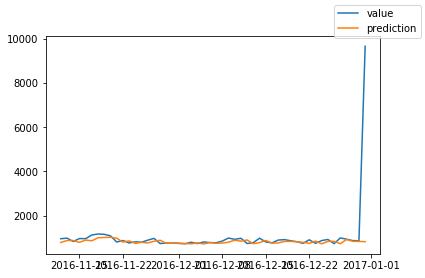

In [100]:
f_o = 0 # offset into the future: 0 next hour, 1 predeciton of next hour +1
last_test_data_index = min(len(test_data), f_o + prediction_real.shape[0])
prediction_df = test_data[f_o: last_test_data_index].assign(prediction=prediction_real[0: last_test_data_index - f_o, f_o])

plt.plot(prediction_df.index, prediction_df["value"], label="value")
plt.plot(prediction_df.index, prediction_df["prediction"], label="prediction")
plt.gcf().legend()

In [98]:
stats = []
for f_o in tqdm(range(prediction_real.shape[1])):
    last_test_data_index = min(len(test_data), f_o + prediction_real.shape[0])
    prediction_df = test_data[f_o: last_test_data_index].assign(prediction=prediction_real[0: last_test_data_index - f_o, f_o])
    prediction_df.reset_index(inplace=True)
    foobar = HelperFunction.TimeSeriesPlot(prediction_df, target_column, "prediction")
    stats.append([foobar.rmse(), foobar.mape(), foobar.mae()])
df_stats = pd.DataFrame(stats, columns=["rmse", "mape", "mae"])
df_stats

100%|██████████| 5/5 [00:00<00:00, 102.07it/s]


,rmse,mape,mae
0,1253.369965,11.645740,265.451539
1,1265.156901,12.178234,275.090352
2,1277.917527,12.065521,277.701935
3,1293.128789,12.768168,289.293214
4,1315.733933,12.448464,291.819003


In [ ]:
t = df_stats.plot()
#t.get_figure().savefig("../results/seq2seq_forecast_24h_book.png")

In [ ]:
prediction = np.loadtxt(os.path.join(DATA_PATH, "predictions_inversed.csv"))
#np.savetxt(os.path.join(DATA_PATH, "predictions_inversed.csv"), prediction)

In [ ]:
#np.save(os.path.join(DATA_PATH, "x_embedded"), X_embedded)
#sal = np.load(os.path.join(DATA_PATH, "saliency_feature_ole.npy"))
X_embedded = np.load(os.path.join(DATA_PATH, "x_embedded.npy"))
prediction = np.load(os.path.join(DATA_PATH, "prediction_ole_numfeatures=1.npy"))

In [101]:
def sum_abs_diff_batch(a, b):
    return np.sum(np.abs(a-b), 1)

test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
mini_batch = 10
batch_count = int(len(test_data) / mini_batch) * mini_batch
prediction = np.empty((int(batch_count/mini_batch), mini_batch, seq_len))
mask = torch.zeros(num_features).to(device)

with torch.no_grad():
    for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
        seq = torch.FloatTensor([test_inputs[i+j:i+j+seq_len] for j in range(mini_batch)]).to(device)
        pred = model(seq).cpu().numpy() # pred.shape = [batch, 24]
        pred_ = np.empty((seq_len, mini_batch, out_seq_len))
        for j in range(seq_len):
            feature_vector_batch = seq[:, j].clone()
            seq[:, j] = mask
            pred_[j] = model(seq).cpu().numpy()
            seq[:, j] = feature_vector_batch
        prediction[batch] = np.array([sum_abs_diff_batch(pred, p) for p in pred_]).swapaxes(0, 1)

sal = prediction.reshape(-1, seq_len)

100%|██████████| 5/5 [00:00<00:00, 22.23it/s]


In [118]:
def sum_abs_diff_batch(a, b):
    return np.sum(np.abs(a-b), 1)

def saliancy_per_sample_seq(model, input, desired_batch_size=100):
    """
    Computes the absolute difference between a prediction and a prediction where for each timestep the features where set
    to zero for each sample
    :param model: Some Pytorch.nn Model
    :param input: Input must be of shape [samples, seq_len, features]
    :param desired_batch_size:
    :return: Returns a np.array of shape [samples, seq_len] where the second dimension is the absolut difference
    between the original prediction and the prediction by setting that specific timestep to zero
    """
    prediction = []
    with torch.no_grad():
        mask = torch.zeros(input.shape[2]).to(next(model.parameters()).device)
        for batch, (batch_start, batch_size) in enumerate(batch_iterator(len(input), desired_batch_size)):
            seq = input[batch_start: batch_start + batch_size]
            pred = model(seq).cpu().numpy()
            pred_ = np.empty((input.shape[1], batch_size, pred.shape[-1]))
            for feature in range(input.shape[1]):
                feature_vector_batch = seq[:, feature].clone()
                seq[:, feature] = mask
                pred_[feature] = model(seq).cpu().numpy()
                seq[:, feature] = feature_vector_batch
            prediction.append(np.array([sum_abs_diff_batch(pred, p) for p in pred_]).swapaxes(0, 1))
    prediction = np.array(prediction)
    return prediction.reshape(-1, input.shape[1])

def saliancy_per_sample(model, input, seq_len, desired_batch_size=100):
    X = create_input_sequence(input, seq_len)
    X = torch.FloatTensor(X).to(next(model.parameters()).device)
    return saliancy_per_sample_seq(model, X, desired_batch_size)

sal2 = saliancy_per_sample(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)))

TypeError: saliancy_per_sample() missing 1 required positional argument: 'seq_len'

In [127]:
sal2.shape

(51, 24, 1)

In [126]:
sal.shape

(0, 24, 1)

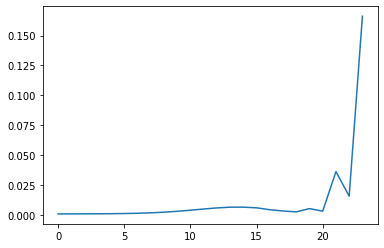

In [122]:
plt.plot(np.mean(sal, axis=0))

In [128]:
def sum_abs_diff_batch(a, b):
    return np.sum(np.abs(a-b), 1)

def saliancy_per_feature_timestep(input, seq_len, out_seq_len, num_features, model, mini_batch=100):
    batch_count = int((len(input) - seq_len) / mini_batch) * mini_batch
    prediction = np.empty((int(batch_count / mini_batch), mini_batch, seq_len, num_features))
    mask_mat = (torch.eye(num_features) - torch.ones(num_features)).abs().to(device)

    with torch.no_grad():
        for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
            seq = torch.FloatTensor([input[i+j:i+j+seq_len] for j in range(mini_batch)]).to(device)
            pred = model(seq).cpu().numpy()
            pred_ = np.empty((seq_len, num_features, mini_batch, out_seq_len))
            for j in range(seq_len):
                feature_vector_batch = seq[:, j].clone()
                for k in range(num_features):
                    seq[:, j] = feature_vector_batch * mask_mat[k]
                    pred_[j, k] = model(seq).cpu().numpy()
                    seq[:, j] = feature_vector_batch
            prediction[batch] = np.array([[sum_abs_diff_batch(pred, f) for f in s] for s in pred_]).transpose((2, 0, 1))
    return prediction.reshape(-1, seq_len, num_features)

test_inputs = np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)).tolist()
sal = saliancy_per_feature_timestep(test_inputs, seq_len, out_seq_len, num_features, model)

0it [00:00, ?it/s]


In [129]:
def saliancy_per_feature_seq(model, input, desired_batch_size=100):
    """
    Computes the absolute difference between a prediction and a prediction where for each timestep each features is set
    to zero for each sample
    :param model: Some Pytorch.nn Model
    :param input: Input must be of shape [samples, seq_len, features]
    :param desired_batch_size:
    :return: Returns a np.array of shape [samples, seq_len, num_features] where each value corresponds to setting
    that feature of that sample to zero
    """
    prediction = []
    with torch.no_grad():
        mask_mat = (torch.eye(input.shape[2]) - torch.ones(input.shape[2])).abs().to(next(model.parameters()).device)
        for batch, (batch_start, batch_size) in enumerate(batch_iterator(len(input), desired_batch_size)):
            seq = input[batch_start: batch_start + batch_size]
            pred = model(seq).cpu().numpy()
            pred_ = np.empty((input.shape[1], input.shape[2], batch_size, pred.shape[-1]))
            for timestep in range(input.shape[1]):
                feature_vector_batch = seq[:, timestep].clone()
                for feature in range(input.shape[2]):
                    seq[:, timestep] = feature_vector_batch * mask_mat[feature]
                    pred_[timestep, feature] = model(seq).cpu().numpy()
                    seq[:, timestep] = feature_vector_batch
            prediction.append(np.array([[sum_abs_diff_batch(pred, f) for f in s] for s in pred_]).transpose((2, 0, 1)))
    prediction = np.array(prediction)
    return prediction.reshape(-1, input.shape[1], input.shape[2])

def saliancy_per_feature(model, input, seq_len, desired_batch_size=100):
    X = create_input_sequence(input, seq_len)
    X = torch.FloatTensor(X).to(next(model.parameters()).device)
    return saliancy_per_feature_seq(model, X, desired_batch_size)

sal = saliancy_per_feature(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)

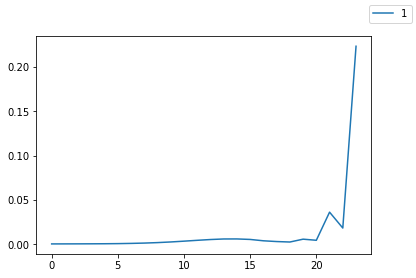

In [130]:
for i in range(0, num_features):
    plt.plot(np.mean(sal[:,:,i], axis=0), label=i+1)

plt.gcf().legend()

In [ ]:
test_inputs, _ = create_input_output_sequence(np.vstack((train_data_scaled[-seq_len:].tolist(), test_data_scaled)), seq_len, out_seq_len)

In [ ]:
mini_batch = 100
batch_count = int(test_inputs.shape[0] / mini_batch) * mini_batch
lstm = model.lstm_in

states = []
with torch.no_grad():
    for batch, i in enumerate(tqdm(range(0, batch_count, mini_batch))):
        _, (h, _) = lstm(test_inputs[i:i+mini_batch])
        states.append(h[-1].cpu().numpy()) # h[-1] last layer
states = np.array(states).reshape(-1, model.hidden_dim)

In [ ]:
X_embedded = TSNE(n_components=2, verbose=1, n_jobs=-1, perplexity=10).fit_transform(states)

In [ ]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=prediction[:X_embedded.shape[0], 0], s=1)
plt.viridis()

In [ ]:
weights = np.ones(48)
weights[-1] = 48
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.average(test_inputs[:X_embedded.shape[0]].reshape(-1, 48), axis=1, weights=weights), s=1)
plt.viridis()

In [ ]:
weights = np.ones(48)
weights[-1] = 48
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=np.average(test_inputs[:X_embedded.shape[0]].reshape(-1, 48), axis=1, weights=weights), s=1)
plt.viridis()